## Imports

In [193]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from keras_cv.losses import FocalLoss
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

## Read the data

In [133]:
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset-training-master.csv')
test_data_dir = os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset-testing-master.csv')

In [134]:
df = pd.read_csv(data_dir)

In [135]:
df.head(10)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0
6,9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0
7,10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0
8,11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0
9,12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0


In [136]:
df.drop(columns='CustomerID', inplace=True)

In [137]:
print(df.isna().sum())

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [138]:
df.dropna(inplace=True)

Prepare test data.

In [139]:
df_test = pd.read_csv(os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset-testing-master.csv'))
df_test.dropna(inplace=True)
df_test.drop(columns='CustomerID', inplace=True)

Convert data types

In [140]:
int_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
for col in int_cols:
    df[col] = df[col].astype('int64')
    df_test[col] = df_test[col].astype('int64')

categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_cols:
    df[col] = df[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  int64   
 1   Gender             440832 non-null  category
 2   Tenure             440832 non-null  int64   
 3   Usage Frequency    440832 non-null  int64   
 4   Support Calls      440832 non-null  int64   
 5   Payment Delay      440832 non-null  int64   
 6   Subscription Type  440832 non-null  category
 7   Contract Length    440832 non-null  category
 8   Total Spend        440832 non-null  int64   
 9   Last Interaction   440832 non-null  int64   
 10  Churn              440832 non-null  int64   
dtypes: category(3), int64(8)
memory usage: 31.5 MB


In [142]:
df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.344771,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.722712,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


## Feature Engineering

In [143]:
df['Spend_per_Tenure'] = df['Total Spend'] / (df['Tenure'] + 1)  # Avoid division by zero
df['SupportCalls_per_Tenure'] = df['Support Calls'] / (df['Tenure'] + 1)
df['Usage_per_Tenure'] = df['Usage Frequency'] / (df['Tenure'] + 1)

df_test['Spend_per_Tenure'] = df_test['Total Spend'] / (df_test['Tenure'] + 1)
df_test['SupportCalls_per_Tenure'] = df_test['Support Calls'] / (df_test['Tenure'] + 1)
df_test['Usage_per_Tenure'] = df_test['Usage Frequency'] / (df_test['Tenure'] + 1)

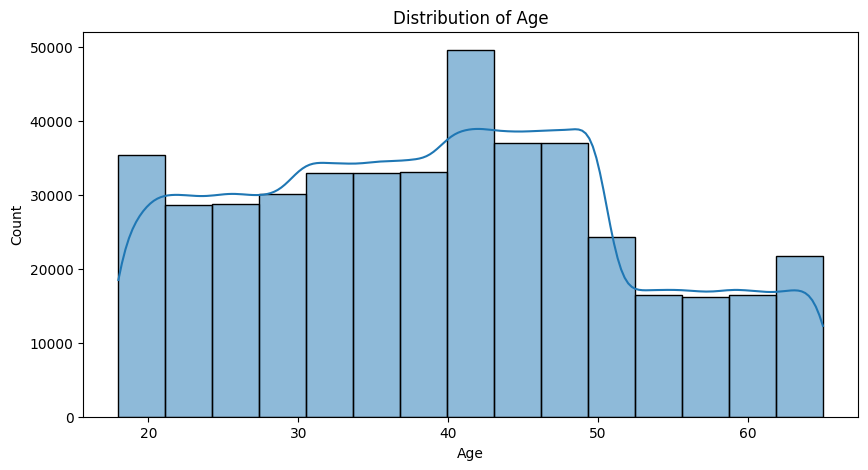

In [144]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=15, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()

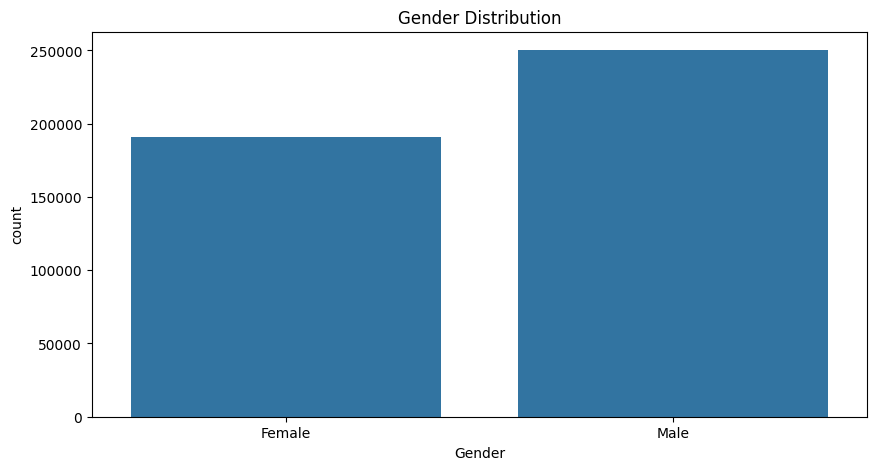

In [145]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

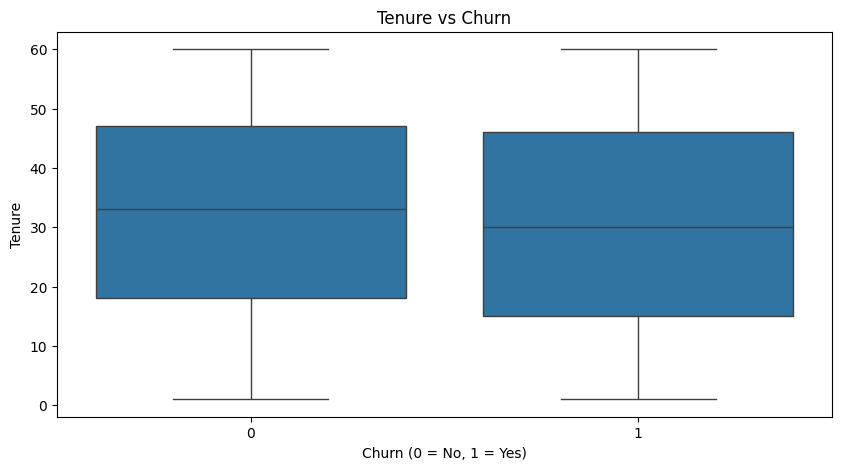

In [146]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

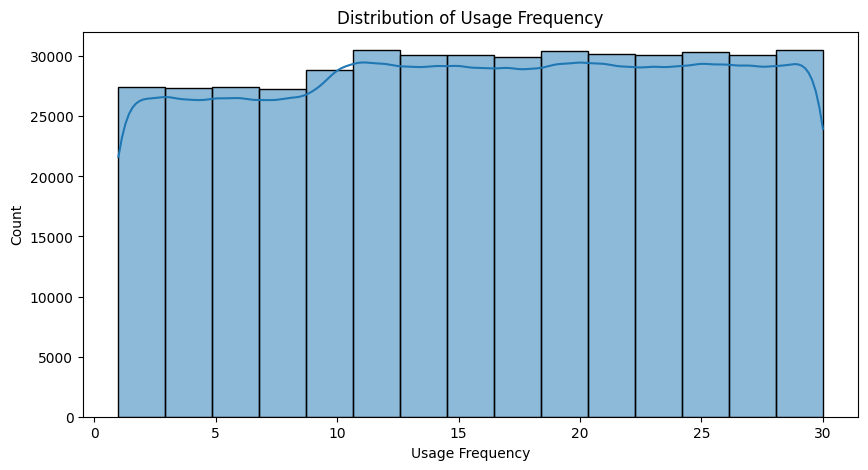

In [147]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Usage Frequency'], bins=15, kde=True)
plt.title('Distribution of Usage Frequency')
plt.xlabel('Usage Frequency')
plt.show()

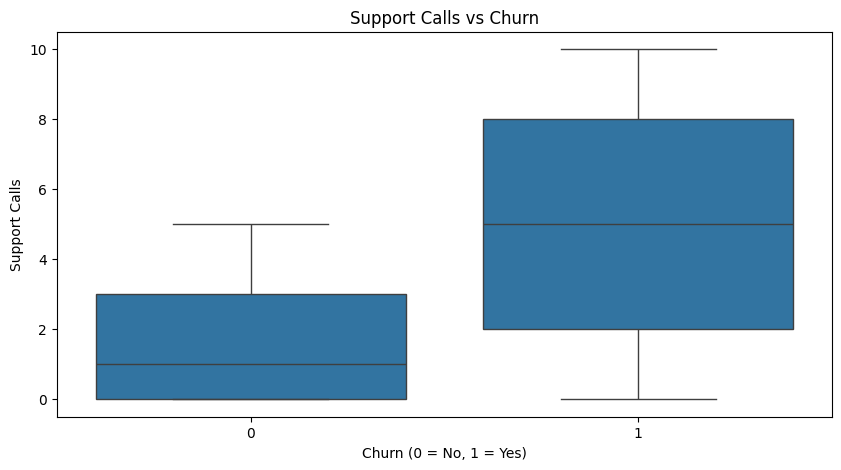

In [148]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Support Calls', data=df)
plt.title('Support Calls vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

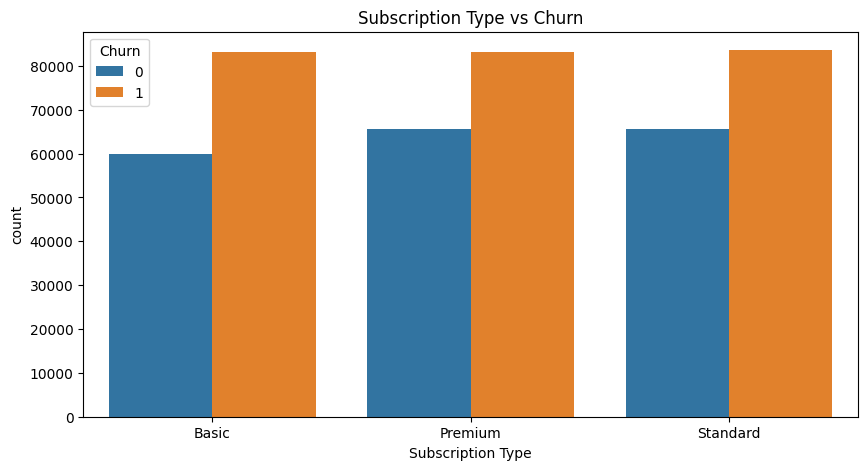

In [149]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Subscription Type', hue='Churn', data=df)
plt.title('Subscription Type vs Churn')
plt.show()

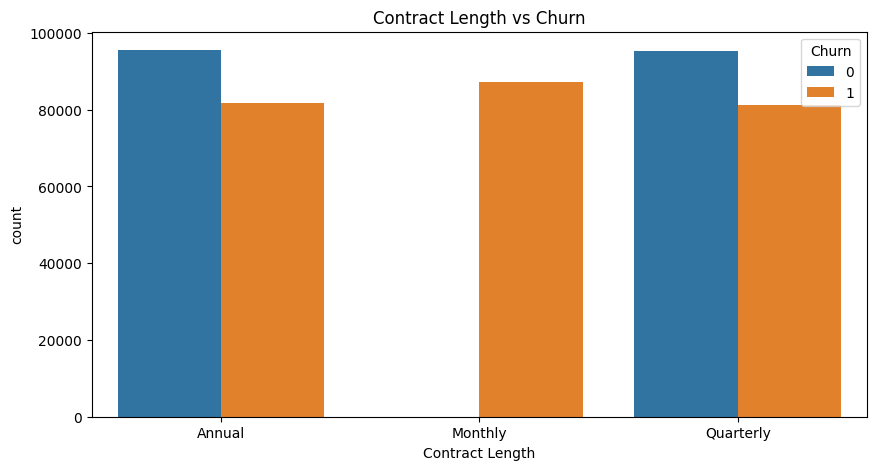

In [150]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Contract Length', hue='Churn', data=df)
plt.title('Contract Length vs Churn')
plt.show()

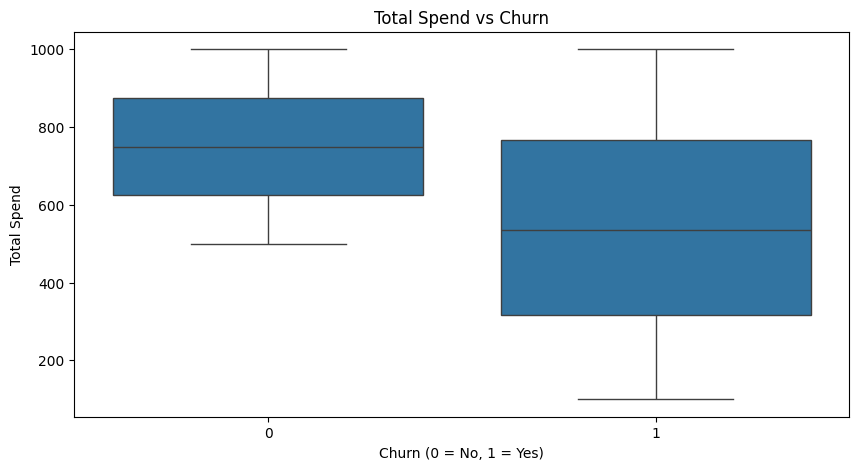

In [151]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Total Spend', data=df)
plt.title('Total Spend vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

In [152]:
gender_map = {'Male': 0, 'Female': 1}
subscription_map = {'Basic': 0, 'Premium': 1, 'Pro': 2}
Contract_Length = {'Annual': 0, 'Quarterly': 1, 'Monthly' : 2}

In [153]:
df['Gender'] = df['Gender'].map(gender_map)
df['Subscription Type'] = df['Subscription Type'].map(subscription_map)
df['Contract Length'] = df['Contract Length'].map(Contract_Length)
df_test['Gender'] = df_test['Gender'].map(gender_map)
df_test['Subscription Type'] = df_test['Subscription Type'].map(subscription_map)
df_test['Contract Length'] = df_test['Contract Length'].map(Contract_Length)

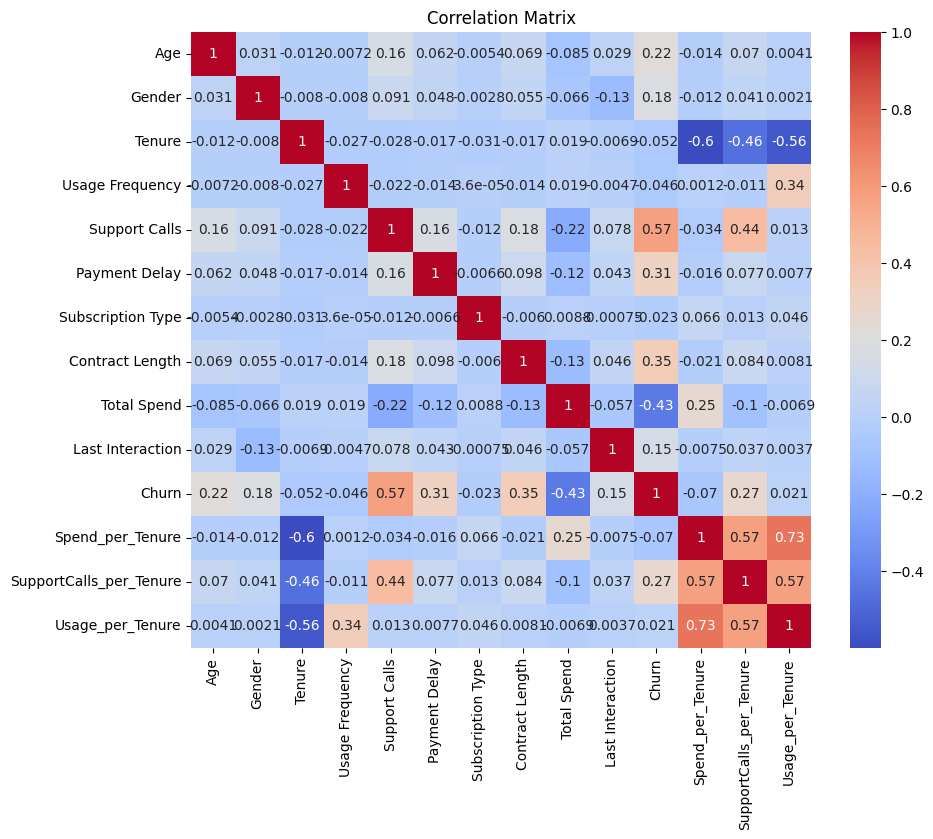

In [154]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

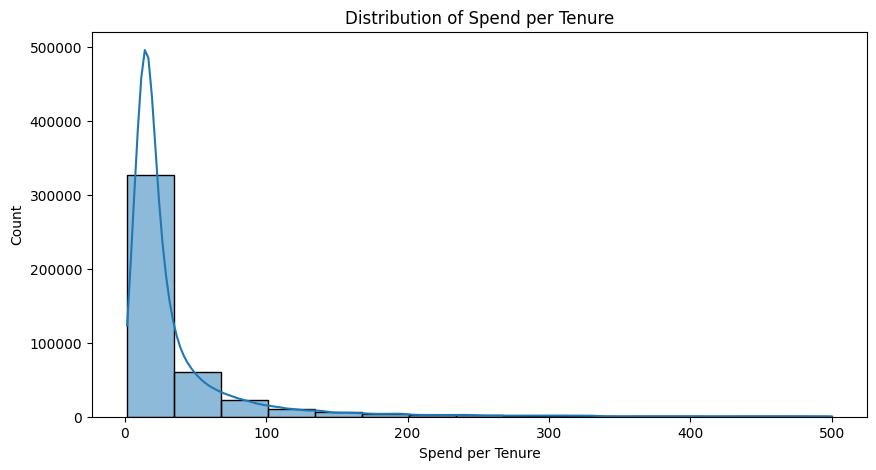

In [155]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Spend_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Spend per Tenure')
plt.xlabel('Spend per Tenure')
plt.show()

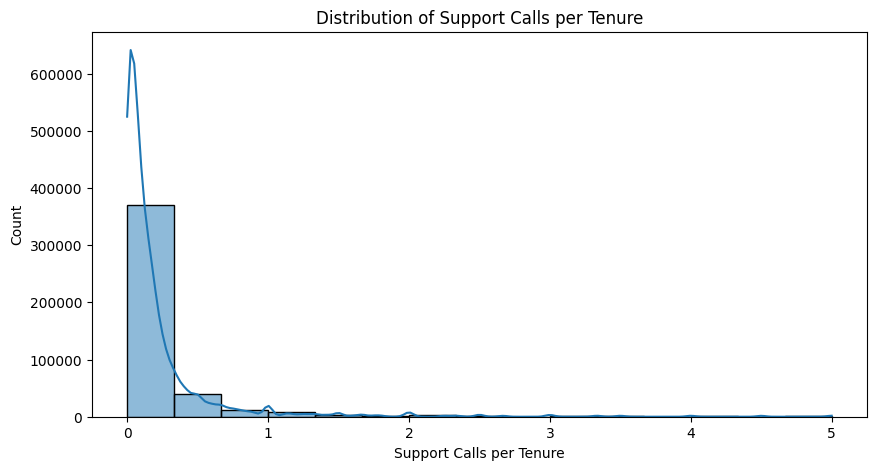

In [156]:
plt.figure(figsize=(10, 5))
sns.histplot(df['SupportCalls_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Support Calls per Tenure')
plt.xlabel('Support Calls per Tenure')
plt.show()

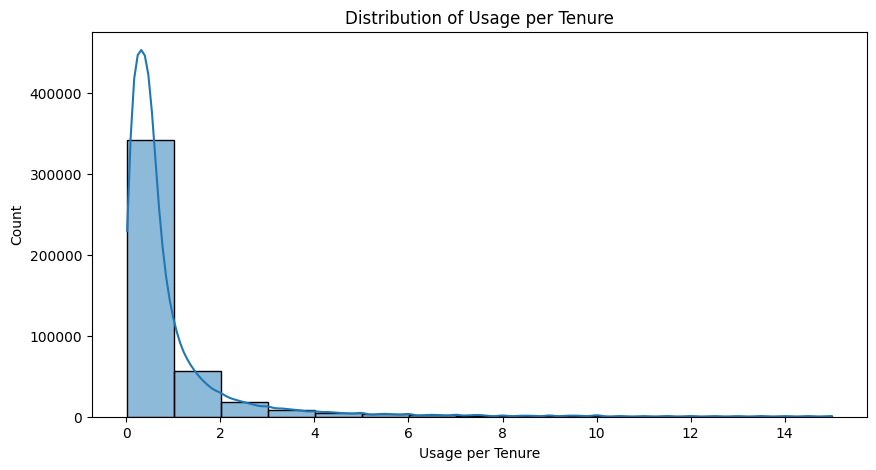

In [157]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Usage_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Usage per Tenure')
plt.xlabel('Usage per Tenure')
plt.show()

In [158]:
threshold = 0.03

correlation_matrix = df.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["Churn"]) > threshold].tolist()
high_corr_features.remove("Churn")
print(high_corr_features)

['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Contract Length', 'Total Spend', 'Last Interaction', 'Spend_per_Tenure', 'SupportCalls_per_Tenure']


In [159]:
X_train = df[high_corr_features]
y_train = df["Churn"]
X_test = df_test[high_corr_features]
y_test = df_test['Churn']

## Build Deep Learning Model

Create TensorBoard logger

In [160]:
logger1 = TensorBoard(
    log_dir=os.path.join(project_dir, 'models', 'logs', 'model1'),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

Scale the features and target

In [161]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Build the model

In [162]:
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

c:\Users\uif93590\Desktop\SoftwareProjects\customer-churn-analysis\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [163]:
history1 = model1.fit(X_train_scaled, y_train, epochs=8, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[logger1])

Epoch 1/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - accuracy: 0.9325 - loss: 0.1630 - val_accuracy: 0.5120 - val_loss: 26.0448
Epoch 2/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.9855 - loss: 0.0475 - val_accuracy: 0.5095 - val_loss: 29.7801
Epoch 3/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.9878 - loss: 0.0412 - val_accuracy: 0.5118 - val_loss: 29.8447
Epoch 4/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9882 - loss: 0.0396 - val_accuracy: 0.5099 - val_loss: 30.8317
Epoch 5/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9892 - loss: 0.0370 - val_accuracy: 0.5104 - val_loss: 31.7091
Epoch 6/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9900 - loss: 0.0344 - val_accuracy: 0.5110 - val_loss: 32.8283
Epoch 7/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.9899 - loss: 0.0345 - val_accuracy: 0.5084 - val_loss: 34.3982
Epoch 8/8
13776/13776 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0

Save the model

In [164]:
model1_path = os.path.join(project_dir, 'models', 'model1.keras')

In [165]:
model1.save(model1_path)

Load the model

In [166]:
# model1 = load_model(model1_path)

Predict

In [167]:
y_pred_prob1 = model1.predict(X_test_scaled)
y_pred1 = (y_pred_prob1 > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

2012/2012 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


Plot Training & Validation Accuracy

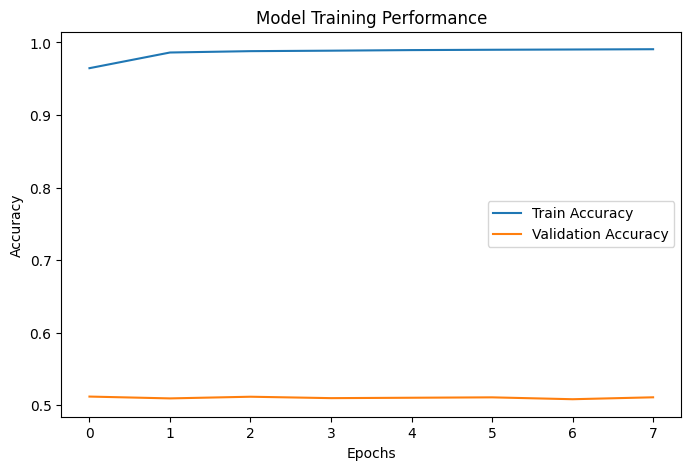

In [168]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training Performance')
plt.legend()
plt.show()

Model1 Performance

In [169]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"\nANN Model Accuracy: {accuracy1:.4f}")
print(classification_report(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))


ANN Model Accuracy: 0.5110
              precision    recall  f1-score   support

           0       0.97      0.07      0.14     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.51     64374
   macro avg       0.73      0.54      0.40     64374
weighted avg       0.74      0.51      0.38     64374

Confusion Matrix:
 [[ 2486 31395]
 [   82 30411]]


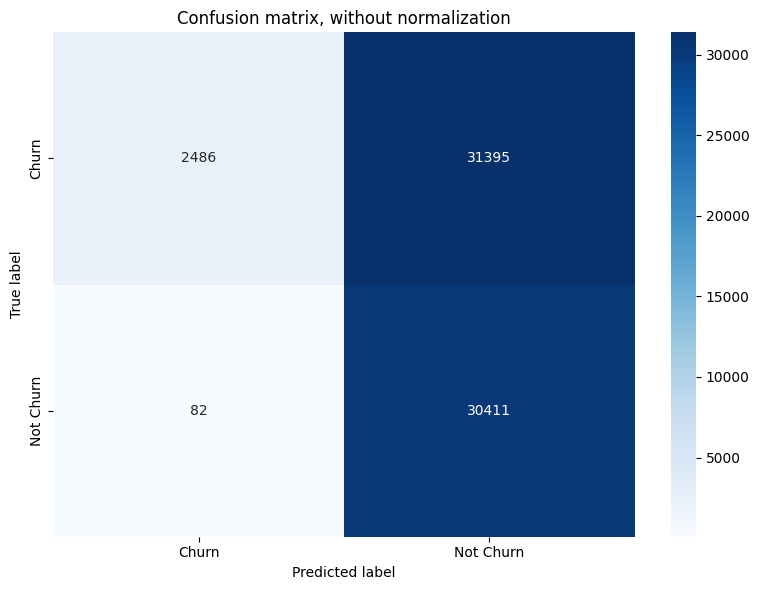

In [170]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Churn', 'Not Churn'], yticklabels=['Churn', 'Not Churn'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### Summary
* 97% precision for non-churn means when the model predicts "not churn", it’s correct 97% of the time. But 49% precision for churn means nearly half of those predictions are wrong.
* 7% recall for non-churn means the model misses 93% of actual "not churn" customers. 100% recall for churn means every actual churn case is predicted as churn.
* The F1-score for non-churn is very low (14%), meaning the model is failing to correctly classify these customers.

### Possible solutions
* Balancing the dataset using SMOTE
* Using Focal Loss to improve prediction penalties
* Adjusting class weights (force the model to pay more attention to non-churn cases)

### Update with SMOTE to handle class imbalance

In [171]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [172]:
X_train_smote_scaled = scaler.fit_transform(X_train_smote)

In [173]:
logger2 = TensorBoard(
    log_dir=os.path.join(project_dir, 'models', 'logs', 'model2'),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

In [174]:
model2 = Sequential([
    Input(shape=(X_train_smote_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [175]:
model2.compile(
    optimizer='adam',
    loss=FocalLoss(from_logits=False, gamma=2.0),  # Focal loss to handle imbalance
    metrics=['accuracy']
)

In [176]:
model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [178]:
history2 = model2.fit(
    X_train_smote_scaled, y_train_smote,
    epochs=30,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[logger2, early_stopping]
)

Epoch 1/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.5006 - loss: 0.0722 - val_accuracy: 0.5263 - val_loss: 0.0714
Epoch 2/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.5005 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0714
Epoch 3/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.4987 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0714
Epoch 4/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.4990 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0713
Epoch 5/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.5006 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0714
Epoch 6/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.5006 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0712
Epoch 7/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.4985 - loss: 0.0719 - val_accuracy: 0.5263 - val_loss: 0.0714
Epoch 8/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.5008 - loss: 0

In [179]:
y_pred_prob2 = model2.predict(X_test_scaled)
y_pred2 = (y_pred_prob2 > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

2012/2012 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [180]:
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"\nANN Model Accuracy: {accuracy2:.4f}")
print(classification_report(y_test, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred2))


ANN Model Accuracy: 0.5263
              precision    recall  f1-score   support

           0       0.53      1.00      0.69     33881
           1       0.00      0.00      0.00     30493

    accuracy                           0.53     64374
   macro avg       0.26      0.50      0.34     64374
weighted avg       0.28      0.53      0.36     64374

Confusion Matrix:
 [[33881     0]
 [30493     0]]


c:\Users\uif93590\Desktop\SoftwareProjects\customer-churn-analysis\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\uif93590\Desktop\SoftwareProjects\customer-churn-analysis\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\uif93590\Desktop\SoftwareProjects\customer-churn-analysis\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Even after SMOTE, the model is overfitting to churned customers.
The model learns to predict "churn" (1) all the time because that minimizes binary cross-entropy loss.

### Model3 with Weighted Binary Cross-Entropy

Instead of Focal Loss, use Weighted Binary Cross-Entropy, which assigns higher loss for mistakes on the minority class.

Define Weighted Binary Cross-Entropy loss

In [184]:
def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_0 = 0.75
    weight_for_1 = 1.25

    bce = K.binary_crossentropy(y_true, y_pred)
    weights = y_true * weight_for_1 + (1 - y_true) * weight_for_0
    return K.mean(weights * bce)

Try adding batch normalization and more neurons in hidden layers.

In [183]:
model3 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [185]:
model3.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [188]:
logger3 = TensorBoard(
    log_dir=os.path.join(project_dir, 'models', 'logs', 'model3'),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

In [189]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(1.1550203581141627), 1: np.float64(0.8816675266701067)}


In [190]:
history3 = model3.fit(
    X_train_scaled, y_train, 
    epochs=50,                  
    batch_size=64, 
    validation_data=(X_test_scaled, y_test), 
    class_weight=class_weight_dict,
    callbacks=[logger3, early_stopping]
)

Epoch 1/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9404 - loss: 0.1451 - val_accuracy: 0.5163 - val_loss: 4.7624
Epoch 2/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9799 - loss: 0.0622 - val_accuracy: 0.5111 - val_loss: 5.0067
Epoch 3/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9832 - loss: 0.0547 - val_accuracy: 0.5103 - val_loss: 5.0148
Epoch 4/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9842 - loss: 0.0519 - val_accuracy: 0.5101 - val_loss: 4.9733
Epoch 5/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9858 - loss: 0.0472 - val_accuracy: 0.5112 - val_loss: 5.0328
Epoch 6/50
6888/6888 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9866 - loss: 0.0441 - val_accuracy: 0.5109 - val_loss: 5.0289


In [191]:
y_pred_prob3 = model3.predict(X_test_scaled)
y_pred3 = (y_pred_prob3 > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

2012/2012 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
accuracy3 = accuracy_score(y_test, y_pred3)
print(f"\nANN Model Accuracy: {accuracy3:.4f}")
print(classification_report(y_test, y_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred3))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob3):.4f}")


ANN Model Accuracy: 0.5163
              precision    recall  f1-score   support

           0       0.96      0.08      0.16     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.52     64374
   macro avg       0.73      0.54      0.41     64374
weighted avg       0.74      0.52      0.40     64374

Confusion Matrix:
 [[ 2877 31004]
 [  133 30360]]
